Using device: cuda
Loading and preprocessing data...
Model input size: 6 features per frame.
Training the LSTM model...

Starting training with early stopping...
Epoch [1/50], Batch [100/397], Train Loss: 0.2286
Epoch [1/50], Batch [200/397], Train Loss: 0.2358
Epoch [1/50], Batch [300/397], Train Loss: 0.2845
Epoch [1/50] | Train Loss: 0.2387 | Val Loss: 0.1782 | Val Acc: 0.9267 | Val EER: 14.5604% | Val ROC AUC: 0.9364
--- Improved validation loss. Saving model from epoch 1. ---
Epoch [2/50], Batch [100/397], Train Loss: 0.1805
Epoch [2/50], Batch [200/397], Train Loss: 0.1069
Epoch [2/50], Batch [300/397], Train Loss: 0.1481
Epoch [2/50] | Train Loss: 0.1519 | Val Loss: 0.1719 | Val Acc: 0.9351 | Val EER: 13.1476% | Val ROC AUC: 0.9470
--- Improved validation loss. Saving model from epoch 2. ---
Epoch [3/50], Batch [100/397], Train Loss: 0.0971
Epoch [3/50], Batch [200/397], Train Loss: 0.1480
Epoch [3/50], Batch [300/397], Train Loss: 0.2011
Epoch [3/50] | Train Loss: 0.1351 | Val 

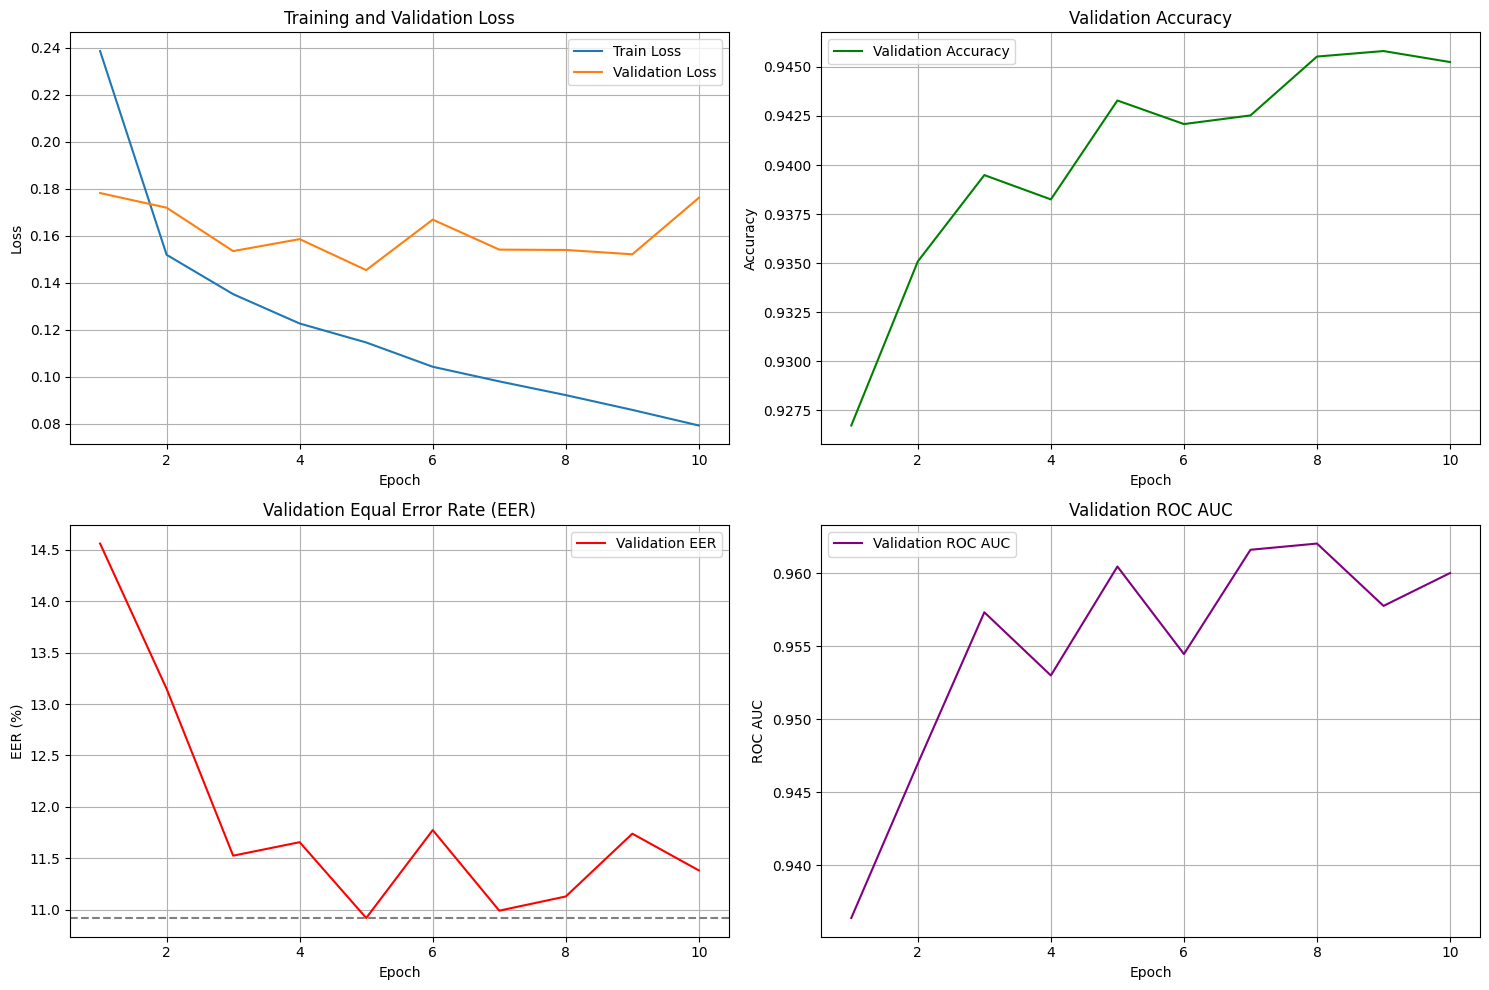


Loading best model from 'best_lstm_spoofing_detector.pth' for final evaluation...

Performing final evaluation on the development set using the best model...

===== Model Final Evaluation Results =====
Accuracy: 0.9433
Precision: 0.7725
Recall: 0.6291
F1 Score: 0.6935
Equal Error Rate (EER): 10.9190%
EER Threshold: 0.0849
ROC AUC: 0.9605
Confusion Matrix:
[[21966   472]
 [  945  1603]]

Training and Evaluation Process Complete!


In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import brentq # For EER calculation
from scipy.interpolate import interp1d # For EER calculation

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- Define paths to the data files ---
# Using the paths you provided in the last interaction (Linux-like paths)
TRAIN_DATA_PATH = "/mount/studenten/arbeitsdaten-studenten1/team-lab-phonetics/2025/student_directories/AuFa/merged_features_train.csv"
DEV_DATA_PATH = "/mount/studenten/arbeitsdaten-studenten1/team-lab-phonetics/2025/student_directories/AuFa/merged_features_dev.csv"

# Define the feature columns to use
FEATURE_COLS = ['mean_f0', 'std_f0', 'jitter', 'shimmer', 'mean_hnr', 'std_hnr']

# --- Define hyperparameters ---
BATCH_SIZE = 64
HIDDEN_SIZE = 128
NUM_LAYERS = 2
DROPOUT = 0.2
LEARNING_RATE = 0.001
NUM_EPOCHS = 50 # Increased epochs for early stopping to have more room
EARLY_STOPPING_PATIENCE = 5 # Number of epochs to wait for improvement before stopping
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Model Saving Path ---
BEST_MODEL_SAVE_PATH = 'best_lstm_spoofing_detector.pth'
PLOT_SAVE_PATH = 'lstm_training_metrics.png'

# --- Dataset and DataLoader Classes (from your original script) ---
class AudioDataset(Dataset):
    def __init__(self, csv_file, feature_cols=FEATURE_COLS, transform=None):
        self.data = pd.read_csv(csv_file)
        self.feature_cols = feature_cols
        self.transform = transform

        self.file_groups = self.data.groupby('file_id')
        self.file_ids = list(self.file_groups.groups.keys())

        # Create label mapping
        self.labels = {file_id: 1 if label == 'bonafide' else 0
                       for file_id, label in self.data[['file_id', 'label']].drop_duplicates().values}

    def __len__(self):
        return len(self.file_ids)

    def __getitem__(self, idx):
        file_id = self.file_ids[idx]
        file_data = self.file_groups.get_group(file_id)

        # Extract features and sort by window_index
        features = file_data[self.feature_cols].values
        window_indices = file_data['window_index'].values
        sorted_indices = np.argsort(window_indices)
        features = features[sorted_indices]

        # Apply transformation if provided
        if self.transform:
            features = self.transform(features)

        # Convert to tensor
        features_tensor = torch.FloatTensor(features)
        label = self.labels[file_id]
        label_tensor = torch.FloatTensor([label])

        return features_tensor, label_tensor

def collate_fn(batch):
    # Sort batch by sequence length (descending)
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)

    # Get sequences and labels
    sequences, labels = zip(*batch)

    # Get sequence lengths
    lengths = [seq.shape[0] for seq in sequences]

    # Pad sequences
    padded_seqs = nn.utils.rnn.pad_sequence(sequences, batch_first=True)

    # Pack labels
    labels = torch.cat(labels).unsqueeze(1)

    return padded_seqs, lengths, labels

# --- LSTM Model Definition (from your original script) ---
class LSTMSpoofingDetector(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super(LSTMSpoofingDetector, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.attention = nn.Sequential(
            nn.Linear(hidden_size * 2, 1),
            nn.Tanh()
        )

        self.fc = nn.Linear(hidden_size * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, lengths):
        # Pack padded sequence
        packed_x = nn.utils.rnn.pack_padded_sequence(x, lengths, batch_first=True)

        # Pass through LSTM
        packed_output, (hidden, _) = self.lstm(packed_x)

        # Unpack output
        output, _ = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)

        # Apply attention
        batch_size, seq_len, hidden_dim = output.size()
        attention_weights = self.attention(output.reshape(-1, hidden_dim)).view(batch_size, seq_len)
        attention_weights = torch.softmax(attention_weights, dim=1).unsqueeze(2)

        # Apply attention weights to get context vector
        context = torch.sum(output * attention_weights, dim=1)

        # Pass through fully connected layer
        logits = self.fc(context)
        predictions = self.sigmoid(logits)

        return predictions

# --- Metric Calculation Utilities ---
def calculate_eer(y_true, y_score):
    """Calculates the Equal Error Rate (EER)."""
    # y_true: actual labels (0 or 1)
    # y_score: predicted probabilities (scores)
    fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)
    eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
    return eer * 100 # Convert to percentage

# --- Training Function ---
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience, save_path):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_eers = []
    val_roc_aucs = []

    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_epoch = 0

    print("\nStarting training with early stopping...")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0

        for batch_idx, (sequences, lengths, labels) in enumerate(train_loader):
            sequences = sequences.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0: # Print less frequently for cleaner output
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Train Loss: {loss.item():.4f}')

        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        all_scores = [] # Store raw scores for EER and ROC AUC

        with torch.no_grad():
            for sequences, lengths, labels in val_loader:
                sequences = sequences.to(device)
                labels = labels.to(device)

                outputs = model(sequences, lengths)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                preds = (outputs > 0.5).float() # Binary predictions
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_scores.extend(outputs.cpu().numpy()) # Raw probabilities/scores

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation metrics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_accuracies.append(val_accuracy)
        
        val_eer = calculate_eer(np.array(all_labels), np.array(all_scores).flatten()) # Flatten scores for EER
        val_eers.append(val_eer)

        val_roc_auc = roc_auc_score(all_labels, all_scores)
        val_roc_aucs.append(val_roc_auc)

        print(f'Epoch [{epoch+1}/{num_epochs}] | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val EER: {val_eer:.4f}% | Val ROC AUC: {val_roc_auc:.4f}')

        # Early stopping check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            best_epoch = epoch + 1 # Store the epoch number
            # Save the best model state
            torch.save(model.state_dict(), save_path)
            print(f"--- Improved validation loss. Saving model from epoch {best_epoch}. ---")
        else:
            epochs_no_improve += 1
            print(f"--- No improvement for {epochs_no_improve}/{patience} epochs. ---")
            if epochs_no_improve == patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break

    print(f"\nTraining finished. Best model saved from epoch {best_epoch} with Validation Loss: {best_val_loss:.4f}")
    return train_losses, val_losses, val_accuracies, val_eers, val_roc_aucs, len(val_losses) # Return actual epochs run

# --- Evaluation Function (Modified to use scores for EER/ROC AUC) ---
def evaluate_model_final(model, test_loader, device):
    """
    Evaluate the model on the test set, returning comprehensive metrics.
    """
    model.eval()
    all_preds = []
    all_labels = []
    all_scores = [] # Store raw scores for EER and ROC AUC

    with torch.no_grad():
        for sequences, lengths, labels in test_loader:
            sequences = sequences.to(device)
            outputs = model(sequences, lengths)
            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_scores.extend(outputs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    # Ensure all_scores and all_labels are numpy arrays for EER/ROC AUC
    all_labels_np = np.array(all_labels)
    all_scores_np = np.array(all_scores).flatten() # Flatten to 1D for EER/ROC AUC

    roc_auc = roc_auc_score(all_labels_np, all_scores_np)
    eer = calculate_eer(all_labels_np, all_scores_np)

    # To get EER Threshold, we need roc_curve again, specific to the EER point
    fpr, tpr, thresholds = roc_curve(all_labels_np, all_scores_np, pos_label=1)
    eer_threshold_val = 0.0 # Default if EER isn't found
    min_diff = float('inf')
    for i, t in enumerate(thresholds):
        far = fpr[i]
        frr = 1 - tpr[i]
        diff = abs(far - frr)
        if diff < min_diff:
            min_diff = diff
            eer_threshold_val = t
            
    print("\n===== Model Final Evaluation Results =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Equal Error Rate (EER): {eer:.4f}%")
    print(f"EER Threshold: {eer_threshold_val:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f'Confusion Matrix:\n{conf_matrix}')

    return accuracy, precision, recall, f1, eer, eer_threshold_val, roc_auc, conf_matrix

# --- Plotting Function ---
def plot_metrics(train_losses, val_losses, val_accuracies, val_eers, val_roc_aucs, num_epochs_ran, filename):
    epochs = range(1, num_epochs_ran + 1)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 2)
    plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 2, 3)
    plt.plot(epochs, val_eers, label='Validation EER', color='red')
    plt.xlabel('Epoch')
    plt.ylabel('EER (%)')
    plt.title('Validation Equal Error Rate (EER)')
    plt.legend()
    plt.grid(True)
    plt.axhline(y=min(val_eers), color='gray', linestyle='--', label=f'Min EER: {min(val_eers):.4f}%')


    plt.subplot(2, 2, 4)
    plt.plot(epochs, val_roc_aucs, label='Validation ROC AUC', color='purple')
    plt.xlabel('Epoch')
    plt.ylabel('ROC AUC')
    plt.title('Validation ROC AUC')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# --- Main function to run training and evaluation ---
def main():
    print(f"Using device: {DEVICE}")

    # Load and preprocess data
    print("Loading and preprocessing data...")

    # Load the data for scaler fitting
    try:
        train_data_for_scaler = pd.read_csv(TRAIN_DATA_PATH)
    except FileNotFoundError:
        print(f"Error: Training data CSV not found at {TRAIN_DATA_PATH}. Please check the path.")
        sys.exit(1)

    scaler = StandardScaler()
    scaler.fit(train_data_for_scaler[FEATURE_COLS].values)
    transform = lambda x: scaler.transform(x)

    # Create datasets
    train_dataset = AudioDataset(TRAIN_DATA_PATH, transform=transform)
    try:
        val_dataset = AudioDataset(DEV_DATA_PATH, transform=transform)
    except FileNotFoundError:
        print(f"Error: Development data CSV not found at {DEV_DATA_PATH}. Please check the path.")
        sys.exit(1)


    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False, # Do not shuffle validation data
        collate_fn=collate_fn
    )

    # Create model
    input_size = len(FEATURE_COLS)
    print(f"Model input size: {input_size} features per frame.")
    model = LSTMSpoofingDetector(
        input_size=input_size,
        hidden_size=HIDDEN_SIZE,
        num_layers=NUM_LAYERS,
        dropout=DROPOUT
    ).to(DEVICE)

    # Define loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Train the model
    print("Training the LSTM model...")
    train_losses, val_losses, val_accuracies, val_eers, val_roc_aucs, num_epochs_ran = train_model(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        NUM_EPOCHS,
        DEVICE,
        EARLY_STOPPING_PATIENCE,
        BEST_MODEL_SAVE_PATH # Path to save the best model
    )

    # Plot training and validation metrics
    print(f"\nPlotting training results to '{PLOT_SAVE_PATH}'...")
    plot_metrics(train_losses, val_losses, val_accuracies, val_eers, val_roc_aucs, num_epochs_ran, PLOT_SAVE_PATH)

    # Evaluate the BEST model (loaded from saved path)
    print(f"\nLoading best model from '{BEST_MODEL_SAVE_PATH}' for final evaluation...")
    if not os.path.exists(BEST_MODEL_SAVE_PATH):
        print(f"Error: Best model not found at '{BEST_MODEL_SAVE_PATH}'. "
              "This might happen if early stopping was triggered immediately or training failed.")
        sys.exit(1)
        
    model.load_state_dict(torch.load(BEST_MODEL_SAVE_PATH, map_location=DEVICE))
    
    print("\nPerforming final evaluation on the development set using the best model...")
    evaluate_model_final(model, val_loader, DEVICE)

    print("\nTraining and Evaluation Process Complete!")

if __name__ == "__main__":
    main()